In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import sys
import numpy as np
import math
import sklearn.metrics as metrics
from tqdm import tqdm
from gym import Env, spaces
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from tensorflow.python.keras import backend
from tensorflow.keras.backend import clear_session


import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")


In [9]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import csv

import tensorflow as tf
import tensorflow.compat.v1 as tf1
import tensorflow.keras as K

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)


from sklearn.feature_extraction.text import CountVectorizer

In [10]:
def read_and_decode(dataset, batch_size, is_training, data_size,n_patients):
    if is_training:
        dataset = dataset.shuffle(buffer_size=data_size, reshuffle_each_iteration=True)
        dataset = dataset.batch(batch_size, drop_remainder=False)
        dataset = dataset.repeat(None)
    else:
        dataset = dataset.prefetch(buffer_size=data_size // batch_size)
        dataset = dataset.batch(batch_size, drop_remainder=False)
        dataset = dataset.repeat(None)
    return dataset

In [23]:
def create_q_model(n_classes, n_words, n_actions):
    
    # The only change is on this line:
    inputs = K.layers.Input(shape=(n_classes,))

    feat = K.layers.Lambda(lambda x: x[:, 0:n_classes - n_words])(inputs)
    
    emb = K.layers.Dropout(0.05)(feat)
    
    prob = K.layers.Lambda(lambda x: x[:, n_classes - n_words:n_classes])(inputs)
    
    emb = K.layers.Dense(256, activation="relu")(emb)
    
    emb = K.layers.Dropout(0.05)(emb)
    
    emb = K.layers.Concatenate(axis=1)([emb, prob])
    
    action = K.layers.Dense(n_actions, activation=None)(emb)
    
    return K.Model(inputs=inputs, outputs=action)

In [24]:
def initialize_clinical_practice(clinical_cases_feat,clinical_cases_labels,dataset_size,n_classes,is_training,n_patients,set_distribution):

    if is_training:
        _, counts = np.unique(clinical_cases_labels, return_counts=True)

        akiec = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 0), axis=0))
        akiec_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 0), axis=0))

        bcc = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 1), axis=0))
        bcc_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 1), axis=0))

        bkl = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 2), axis=0))
        bkl_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 2), axis=0))

        df = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 3), axis=0))
        df_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 3), axis=0))

        mel = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 4), axis=0))
        mel_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 4), axis=0))

        nv = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 5), axis=0))
        nv_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 5), axis=0))

        vasc = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 6), axis=0))
        vasc_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 6), axis=0))

        akiec_set = tf.data.Dataset.from_tensor_slices((akiec, akiec_labels)).shuffle(buffer_size=counts[0],
                                                                                      reshuffle_each_iteration=True).repeat()
        bcc_set = tf.data.Dataset.from_tensor_slices((bcc, bcc_labels)).shuffle(buffer_size=counts[1],
                                                                                reshuffle_each_iteration=True).repeat()
        bkl_set = tf.data.Dataset.from_tensor_slices((bkl, bkl_labels)).shuffle(buffer_size=counts[2],
                                                                                reshuffle_each_iteration=True).repeat()
        df_set = tf.data.Dataset.from_tensor_slices((df, df_labels)).shuffle(buffer_size=counts[3],
                                                                             reshuffle_each_iteration=True).repeat()
        mel_set = tf.data.Dataset.from_tensor_slices((mel, mel_labels)).shuffle(buffer_size=counts[4],
                                                                                reshuffle_each_iteration=True).repeat()
        nv_set = tf.data.Dataset.from_tensor_slices((nv, nv_labels)).shuffle(buffer_size=counts[5],
                                                                             reshuffle_each_iteration=True).repeat()
        vasc_set = tf.data.Dataset.from_tensor_slices((vasc, vasc_labels)).shuffle(buffer_size=counts[6],
                                                                                   reshuffle_each_iteration=True).repeat()

        dataset_train = tf.data.Dataset.sample_from_datasets([akiec_set, bcc_set, bkl_set, df_set, mel_set, nv_set, vasc_set], weights=set_distribution)
        dataset_train = dataset_train.batch(1)

    else:
        dataset_train = tf.data.Dataset.from_tensor_slices((clinical_cases_feat,clinical_cases_labels))

        dataset_train = read_and_decode(dataset_train, 1, is_training, dataset_size,n_patients)

    patients = iter(dataset_train)

    return patients
    



In [25]:
 def get_next_patient(patients):
        patient_scores,patient_diagnostics = patients.get_next()
    
        return np.squeeze(patient_scores),patient_diagnostics.numpy()[0]


In [26]:

class Dermatologist(Env):

    def __init__(self,patients,n_classes,vocab):
        # Actions we can take, either skin lesion classes or don't know
        self.action_space = spaces.Discrete(len(vocab))
        # Observation space - softmax + features after GAP
        self.observation_space = spaces.Box(-1*math.inf*np.ones((n_classes,)),math.inf*np.ones((n_classes,)))
        # Initialize state
        n_state,n_gt = get_next_patient(patients)
        self.state = n_state
        self.revised_state = self.state
        self.gt = n_gt
        # Set shower length
        self.number_of_patients = 0

    def step(self,patients,n_patients,vocab,action):
        ### UNKN_reward = -1
        reward_table = np.array([[2,-2,-3,	-3,	-2,	-3,	-3,	-1],
                                 [-2,3,	-4,	-4,	-2,	-4,	-4,	-1],
                                 [-2,-2, 1,	-2,	-3,	-2,	-2,	-1],
                                 [-2,-2,-2,	1,-3,	-2,	-2,	-1],
                                 [-4,-3,-5,	-5,	5,-5,	-5,	-1],
                                 [-2,-2,-2,	-2,	-3,	1,	-2,	-1],
                                 [-2,-2,-2,	-2,	-3,	-2,	1,	-1],
                                 ],np.float32)

        ### UNKN_reward = 0
        # reward_table = np.array([[2, -2, -3, -3, -2, -3, -3, 0],
        #                          [-2, 3, -4, -4, -2, -4, -4, 0],
        #                          [-2, -2, 1, -2, -3, -2, -2, 0],
        #                          [-2, -2, -2, 1, -3, -2, -2, 0],
        #                          [-4, -3, -5, -5, 5, -5, -5, 0],
        #                          [-2, -2, -2, -2, -3, 1, -2, 0],
        #                          [-2, -2, -2, -2, -3, -2, 1, 0],
        #                          ], np.float32)

        ### UNKN_reward = 0.5
        # reward_table = np.array([[2, -2, -3, -3, -2, -3, -3, 0.5],
        #                          [-2, 3, -4, -4, -2, -4, -4, 0.5],
        #                          [-2, -2, 1, -2, -3, -2, -2, 0.5],
        #                          [-2, -2, -2, 1, -3, -2, -2, 0.5],
        #                          [-4, -3, -5, -5, 5, -5, -5, 0.5],
        #                          [-2, -2, -2, -2, -3, 1, -2, 0.5],
        #                          [-2, -2, -2, -2, -3, -2, 1, 0.5],
        #                          ], np.float32)

        
        self.revised_state = tf.one_hot(action,len(vocab))

        reward = reward_table[self.gt,action]

        n_state, n_gt = get_next_patient(patients)

        old_gt = self.gt

        self.state = n_state
        self.gt = n_gt

        self.number_of_patients += 1

        # Check if checking patients is done
        if self.number_of_patients >= n_patients:# or old_gt != action:
            done = 1
        else:
            done = 0

            #reward += 1000

        return self.revised_state, self.state, reward,done,old_gt

    def reset(self,clinical_cases_feat,clinical_cases_labels,n_classes,dataset_size,vocab,is_training,n_patients,sample_distribution):
        # Reset clinical practice
        patients = initialize_clinical_practice(clinical_cases_feat,clinical_cases_labels, dataset_size,n_classes,is_training,n_patients,sample_distribution)
        n_state, n_gt = get_next_patient(patients)
        self.state = n_state
        self.revised_state = self.state
        self.gt = n_gt
        # Reset new practice
        self.number_of_patients = 0

        return self.state,patients


              akiec       bcc       bkl            df       mel        nv  \
0      1.239820e-04  0.001757  0.071755  2.613447e-02  0.004628  0.895575   
1      1.564469e-03  0.000353  0.582653  1.401107e-02  0.000817  0.400582   
2      7.310000e-07  0.000002  0.005028  5.290000e-07  0.002840  0.992129   
3      3.012000e-03  0.027224  0.293466  3.917728e-02  0.062816  0.561710   
4      1.044428e-03  0.007633  0.776036  3.400000e-05  0.197736  0.017514   
...             ...       ...       ...           ...       ...       ...   
10010  2.074046e-03  0.001095  0.002900  4.630000e-05  0.991719  0.000645   
10011  9.210000e-06  0.000346  0.001581  4.070000e-05  0.308520  0.689383   
10012  5.650000e-05  0.001307  0.977360  3.800000e-05  0.000746  0.020455   
10013  3.850000e-06  0.000040  0.004911  2.747410e-04  0.214675  0.780093   
10014  2.450000e-05  0.000041  0.013609  5.980000e-05  0.091868  0.894389   

               vasc   dx  
0      2.630000e-05   nv  
1      1.920000e-05  

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 519)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_20 (Lambda)  │ (None, 512)       │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 512)       │          0 │ lambda_20[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 256)       │    131,328 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_21 (Lambda)  │ (None, 7)         │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 263)       │          0 │ dropout_21[0][0], │
│ (Concatenate)       │                   │            │ lambda_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 7)         │      1,848 │ concatenate_10[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,176 (520.22 KB)

 Trainable params: 133,176 (520.22 KB)

 Non-trainable params: 0 (0.00 B)

Starting episode  0
The episode duration was  100
The episode reward was  -206.0
The number of not random actions was  67
The reward of the validation episode was  -5029.0
The balanced accuracy was  0.06505160059758452
Starting episode  1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
The episode duration was  100
The episode reward was  -78.0
The number of not random actions was  83
The reward of the validation episode was  -923.0
The balanced accuracy was  0.14285714285714285
Starting episode  2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

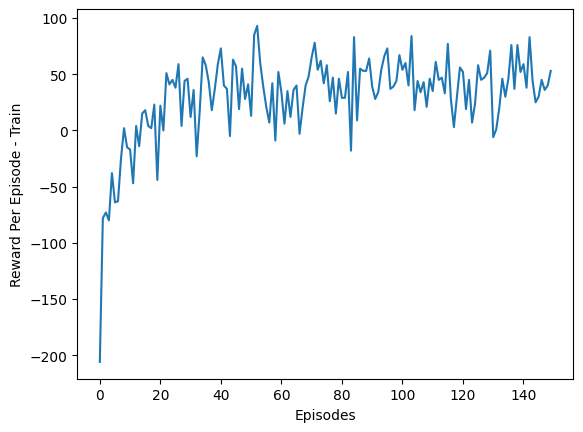

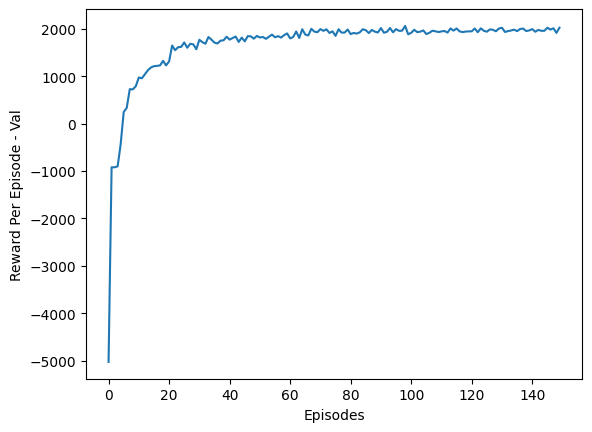

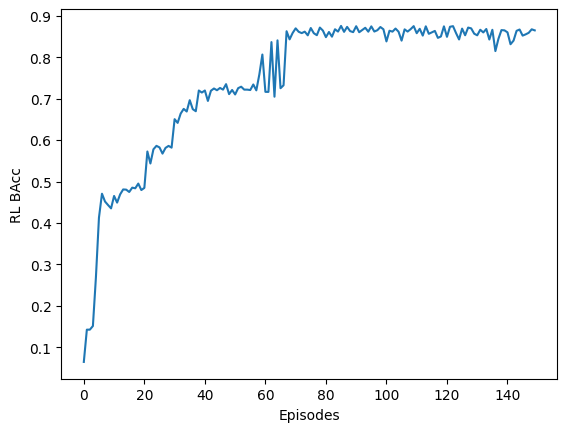

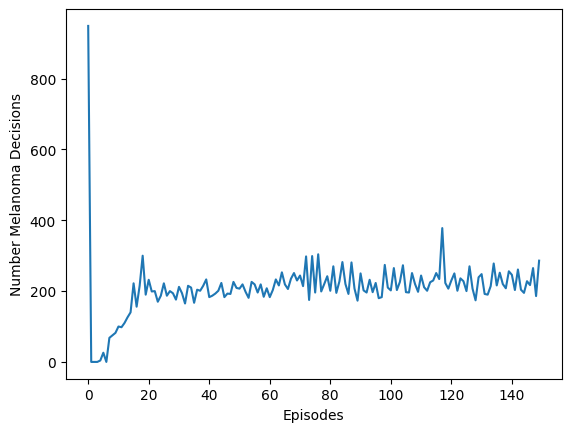

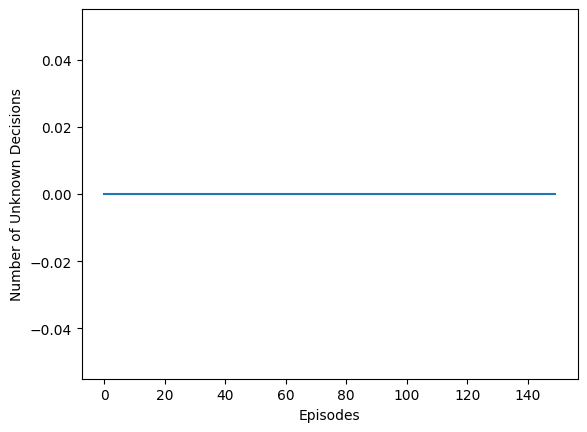

SystemExit: 

C:\Users\nihal\anaconda3\envs\rl-env\Lib\site-packages\IPython\core\interactiveshell.py:3675: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [32]:
def main(_):
    gamma = 0.99  # Discount factor for past rewards
    epsilon = 0.2  # Epsilon greedy parameter
    epsilon_min = 0.1  # Minimum epsilon greedy parameter
    epsilon_max = 0.2  # Maximum epsilon greedy parameter
    epsilon_interval = (epsilon_max - epsilon_min)  # Rate at which to reduce chance of random action being taken

    #### Import Datasets ####
    tf1.enable_eager_execution()

    database = pd.read_csv('data/vectorDB.csv')

    print(database)

    database.head()

    labels = np.asarray(database['dx'])

    print(labels)

    labels[labels == 'scc'] = 'akiec'

    le = preprocessing.LabelEncoder()

    le.fit(labels)

    vocab = le.classes_

    n_words = len(vocab)

    if Flags.use_unknown:
        vocab = np.append(vocab,'unkn')

    features1 = np.load("data/nmed_rn34_ham10k_vectors.npy")

    features2 = pd.read_csv("data/vectorDB.csv")

    features2.pop('dx')

    features2 = np.asarray(features2, dtype='float32')

    features = np.concatenate([features1,features2],axis=1)
    

    _, counts = np.unique(labels, return_counts=True)

    print(counts)

    counts = counts/np.sum(counts)
        

    labels_cat = le.transform(labels)

    print(labels_cat.dtype)

    train_feat, val_feat, train_labels, val_labels = train_test_split(features, labels_cat, test_size=0.2,
                                                                      random_state=111,stratify = labels_cat)


    _, count_train = np.unique(val_labels, return_counts=True)

    print(count_train)

    patients = initialize_clinical_practice(train_feat,train_labels,train_labels.shape[0],True,n_words,Flags.n_patients,counts)

    derm = Dermatologist(patients,n_words,vocab)

    q_network = create_q_model(derm.state.shape[0],n_words,Flags.n_actions)

    q_network.summary()

    target_network = create_q_model(derm.state.shape[0],n_words,Flags.n_actions)

    optimizer = K.optimizers.Adam(learning_rate=0.025, clipnorm=1.0)


    # Experience replay buffers
    action_history = []
    state_history = []
    state_next_history = []
    rewards_history = []
    done_history = []
    episode_reward_history = []
    episode_val_reward_history = []
    validation_bacc_history = []
    mel_history = []
    unk_history = []
    cnn_history = []
    best_bacc = 0
    best_reward = -1*math.inf
    iter_count = 0
    # Number of frames to take random action and observe output
    epsilon_random_frames = 20
    # Number of frames for exploration
    epsilon_greedy_frames = 100000.0
    # Maximum replay length
    max_memory_length = 10000
    # Train the model after 4 actions
    update_after_actions = 10
    # How often to update the target network
    update_target_network = train_feat.shape[0]
    # Using huber loss for stability
    loss_function = K.losses.Huber()

    for episode in range(Flags.n_episodes):
        i = 1
        print('Starting episode ',episode)

        done = False
        episode_score = 0

        episode_val_score = 0

        state = derm.state
        #state = np.concatenate([derm.state, [0]])
        n_not_random = 0
        while not done:
            try:
                iter_count += 1

                # Use epsilon-greedy for exploration
                if iter_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
                    action = derm.action_space.sample()
                else:
                    state_tensor = tf.convert_to_tensor(state)
                    state_tensor = tf.expand_dims(state_tensor, 0)
                    action_probs = q_network(state_tensor, training=False)
                    # Take best action
                    action = tf.argmax(action_probs[0]).numpy()

                    n_not_random += 1

            

                # Decay probability of taking random action
                epsilon -= epsilon_interval / epsilon_greedy_frames
                epsilon = max(epsilon, epsilon_min)

                revised_state,n_state,reward,done,_ = derm.step(patients,Flags.n_patients,vocab,action)

                episode_score += reward

                # Save actions and states in replay buffer
                action_history.append(action)
                state_history.append(state)
                state_next_history.append(n_state)
                done_history.append(done)
                rewards_history.append(reward)
                state = n_state

                i += 1
                # Update every fourth frame
                if iter_count % update_after_actions == 0 and len(done_history) > 100:
                    # Get indices of samples for replay buffers
                    indices = np.random.choice(range(len(done_history)), size=100)

                    # Using list comprehension to sample from replay buffer
                    state_sample = np.array([state_history[i] for i in indices])
                    state_next_sample = np.array([state_next_history[i] for i in indices])
                    rewards_sample = [rewards_history[i] for i in indices]
                    action_sample = [action_history[i] for i in indices]
                    done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])

                    # Build the updated Q-values for the sampled future states
                    # Use the target model for stability
                    future_rewards = target_network.predict(state_next_sample)
                    # Q value = reward + discount factor * expected future reward
                    updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)

                    # If final frame set the last value to -1
                    updated_q_values = updated_q_values * (1 - done_sample) - done_sample

                    # Create a mask so we only calculate loss on the updated Q-values
                    masks = tf.one_hot(action_sample, len(vocab))

                    with tf.GradientTape() as tape:
                        # Train the model on the states and updated Q-values
                        q_values = q_network(state_sample, training=True)

                        # Apply the masks to the Q-values to get the Q-value for action taken
                        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                        # Calculate loss between new Q-value and old Q-value
                        loss = loss_function(updated_q_values, q_action)

                    # Backpropagation
                    grads = tape.gradient(loss, q_network.trainable_variables)
                    optimizer.apply_gradients(zip(grads, q_network.trainable_variables))

                if iter_count % update_target_network == 0:
                    # update the the target network with new weights
                    target_network.set_weights(q_network.get_weights())

                # Limit the state and reward history
                if len(rewards_history) > max_memory_length:
                    del rewards_history[:1]
                    del state_history[:1]
                    del state_next_history[:1]
                    del action_history[:1]
                    del done_history[:1]


            except tf.python.framework.errors_impl.OutOfRangeError:
                done = True
                break

        print('The episode duration was ',i-1)
        print('The episode reward was ',episode_score)
        print('The number of not random actions was ', n_not_random)
        # Update running reward to check condition for solving
        episode_reward_history.append(episode_score)

        ## Validation Phase ##
        state,patients_val = derm.reset(val_feat,val_labels, val_labels.shape[0], n_words, vocab,False,Flags.n_patients,counts)

        done = False

        error = np.array([])
        CNN_error = np.array([])
        true_label = np.array([])

        mel_count = 0

        unk_count = 0

        while not done:
            try:
                true_label = np.append(true_label, derm.gt)

                state_tensor = tf.convert_to_tensor(state)
                state_tensor = tf.expand_dims(state_tensor, 0)
                action_probs = q_network(state_tensor, training=False)
                # Take best action
                action = tf.argmax(action_probs[0]).numpy()

                error = np.append(error, action)

                if vocab[action] == 'mel':
                    mel_count += 1
                elif vocab[action] == 'unkn':
                    unk_count += 1

                _, state, reward, done,_ = derm.step(patients_val, val_labels.shape[0], vocab, action)


                episode_val_score += reward

            except tf.python.framework.errors_impl.OutOfRangeError:
                done = True
                break

        print('The reward of the validation episode was ', episode_val_score)
        print('The balanced accuracy was ', metrics.balanced_accuracy_score(true_label, error))
        episode_val_reward_history.append(episode_val_score)
        validation_bacc_history.append(metrics.balanced_accuracy_score(true_label, error))
        mel_history.append(mel_count)
        unk_history.append(unk_count)

        if best_bacc < metrics.balanced_accuracy_score(true_label, error):
            history_report_bacc = metrics.classification_report(true_label,error,digits=3, zero_division=0)
            history_cov_bacc = metrics.confusion_matrix(true_label,error)
            best_bacc = metrics.balanced_accuracy_score(true_label, error)
            q_network.save_weights('models/best_q_network_diagnosis_bacc.weights.h5')

        if best_reward < episode_val_score:
            history_cov_reward = metrics.confusion_matrix(true_label, error)
            history_report_reward = metrics.classification_report(true_label,error,digits=3, zero_division=0)
            best_reward = episode_val_score
            q_network.save_weights('models/best_q_network_diagnosis_reward.weights.h5')

        ##Return to train
        _,patients = derm.reset(train_feat,train_labels, train_labels.shape[0], n_words, vocab,True,Flags.n_patients,counts)

    q_network.save_weights('models/q_network_diagnosis_final.weights.h5')

    print('The scores for best validation BAcc are:')
    print(history_report_bacc)
    print(history_cov_bacc)
    print('The best BAcc was ',best_bacc)

    print('The scores for best validation Reward are:')
    print(history_report_reward)
    print(history_cov_reward)
    print('The best reward was ', best_reward)

    plt.figure(1)
    plt.plot(episode_reward_history)
    plt.xlabel('Episodes')
    plt.ylabel('Reward Per Episode - Train')
    plt.show()

    plt.figure(2)
    plt.plot(episode_val_reward_history)
    plt.xlabel('Episodes')
    plt.ylabel('Reward Per Episode - Val')
    plt.show()

    plt.figure(3)
    plt.plot(validation_bacc_history)
    plt.xlabel('Episodes')
    plt.ylabel('RL BAcc')
    plt.show()

    plt.figure(4)
    plt.plot(mel_history)
    plt.xlabel('Episodes')
    plt.ylabel('Number Melanoma Decisions')
    plt.show()

    plt.figure(5)
    plt.plot(unk_history)
    plt.xlabel('Episodes')
    plt.ylabel('Number of Unknown Decisions')
    plt.show()

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--n_patients',
        type=int,
        default= 100,
        help='Number of patients per episode.'
    )
    parser.add_argument(
        '--n_episodes',
        type=int,
        default= 150,
        help='Number of episodes to play'
    )
    parser.add_argument(
        '--use_unknown',
        type=bool,
        default=False,
        help='Whether to use unknown action or not distribution'
    )
    parser.add_argument(
        '--n_actions',
        type=int,
        default= 7,
        help='Number of episodes to play'
    )
    Flags, unparsed = parser.parse_known_args()
    tf1.app.run(main=main)